[View in Colaboratory](https://colab.research.google.com/github/myfellowship/myfellowship/blob/master/Predicting%20nodule%20on%20X%20ray.ipynb)

In [81]:
!pip install kaggle

In [82]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [83]:
!kaggle datasets download -d nih-chest-xrays/data -f images_001.zip

100%|██████████████████████████████████████▉| 1.87G/1.87G [00:22<00:00, 116MB/s]
100%|██████████████████████████████████████| 1.87G/1.87G [00:22<00:00, 89.4MB/s]


In [84]:
!ls

adc.json  data	datalab  images_001.zip  labels.npy  sample_data  xrays.npy


In [0]:
import zipfile

def unzipping(file):
  with zipfile.ZipFile(file,"r") as zip_ref:
    zip_ref.extractall("data")
  os.remove(file)

In [0]:
unzipping("images_001.zip")

In [11]:
!ls

adc.json  data	datalab  sample_data


In [88]:
files = os.listdir('data/images')
len(files)

4999

In [9]:
!kaggle datasets download -d nih-chest-xrays/data -f images_002.zip

images_002.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
unzipping("images_002.zip")

In [9]:
files = os.listdir('data/images')
len(files)

4999

getting the list of positive files

In [0]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/gvsanthu10/Dicom/master/onlypositive.csv')

In [90]:
data.head()

,Unnamed: 0,ID,normal,nodule
0,3,00000002_000.png,1,0
1,12,00000004_000.png,0,1
2,13,00000005_000.png,1,0
3,14,00000005_001.png,1,0
4,15,00000005_002.png,1,0


In [91]:
file_list= data['ID'].values
file_list

array(['00000002_000.png', '00000004_000.png', '00000005_000.png', ...,
       '00030803_000.png', '00030804_000.png', '00030805_000.png'],
      dtype=object)

In [15]:
len(file_list)

71568

In [92]:
os.getcwd()

'/content'

In [0]:
os.chdir('data')

In [0]:
for the_file in os.listdir('images'):
  if the_file in file_list:
    pass
  else:
    os.remove(os.path.join('images', the_file))

In [95]:
files = os.listdir('images')
len(files)

3117

**I reduced the number of files from 14999 to 9833** 

In [0]:
files= sorted(files)

In [97]:
file_list

array(['00000002_000.png', '00000004_000.png', '00000005_000.png', ...,
       '00030803_000.png', '00030804_000.png', '00030805_000.png'],
      dtype=object)

**both list are maching**

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [0]:
os.chdir('images')

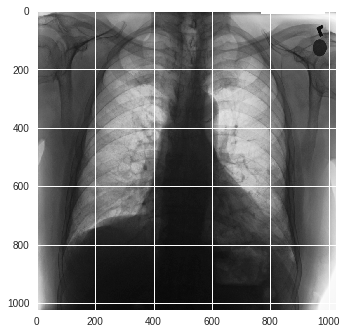

In [100]:
img=mpimg.imread('00000002_000.png')
imgplot = plt.imshow(img)
plt.show()

**this is was normal as from the list**, matching

**Now starting binary classification**

In [101]:
os.getcwd()

'/content/data/images'

In [0]:
os.chdir('..')

In [0]:
os.chdir('..')

*Making labels*

In [0]:
labels = np.array(data['nodule'])

In [105]:
labels

array([0, 1, 0, ..., 0, 0, 0])

Making data

In [106]:
os.getcwd()

'/content'

In [0]:
path = 'data/images/'

In [0]:
from PIL import Image
import cv2 

data=[]

for i in files:
    imag=cv2.imread(os.path.join(path, i))
    img_from_ar = Image.fromarray(imag)
    resized_image = img_from_ar.resize((200, 200))
    data.append(np.array(resized_image))
    

In [0]:
xrays=np.array(data)


In [110]:
xrays.shape

(3117, 200, 200, 3)

In [0]:
labels=labels[:3117]

In [112]:
labels.shape

(3117,)

In [0]:
np.save("xrays",xrays)
np.save("labels",labels)

#we can load these back later
#np.load("xrays",xrays)
#np.load("labels",labels)

In [0]:
#suffuling

s=np.arange(xrays.shape[0])
np.random.shuffle(s)
xrays=xrays[s]
labels=labels[s]

In [0]:
#nuber of categories and number of data (whcih is 2 and 3117)

num_classes=len(np.unique(labels))
data_length=len(xrays)

In [0]:
#diving xrays to train test

(x_train,x_test)=xrays[(int)(0.1*data_length):],xrays[:(int)(0.1*data_length)]

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

train_length=len(x_train)
test_length=len(x_test)

In [0]:
#diving labels to train test

(y_train,y_test)=labels[(int)(0.1*data_length):],labels[:(int)(0.1*data_length)]

In [0]:
#one hot encoder

import keras
from keras.utils import np_utils

#One hot encoding
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

Now making  a model

In [119]:
x_train.shape

(2806, 200, 200, 3)

In [0]:
dataDim = np.prod(xrays[0].shape)

In [0]:
def flatten(dimData, xrays):
    xrays = np.array(xrays)
    xrays = xrays.reshape(len(xrays), dimData)
    return xrays

In [0]:
x_train  = flatten(dataDim, x_train)
x_test = flatten(dataDim, x_test)

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

#three layers
#activation function: both
#neurons: 256
model = Sequential()
model.add(Dense(256, activation = 'tanh', input_shape = (dataDim,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [125]:
history = model.fit(x_train, y_train, batch_size = 50, epochs=10, verbose=1,
                    validation_data=(x_train, y_train))

Train on 2806 samples, validate on 2806 samples
Epoch 1/10
2806/2806 [==============================] - 6s 2ms/step - loss: 0.4405 - acc: 0.8617 - val_loss: 0.3582 - val_acc: 0.8845
Epoch 2/10
2806/2806 [==============================] - 5s 2ms/step - loss: 0.3766 - acc: 0.8842 - val_loss: 0.9199 - val_acc: 0.1155
Epoch 3/10
2806/2806 [==============================] - 5s 2ms/step - loss: 0.3812 - acc: 0.8749 - val_loss: 0.4516 - val_acc: 0.8845
Epoch 4/10
2806/2806 [==============================] - 5s 2ms/step - loss: 0.3783 - acc: 0.8845 - val_loss: 0.3926 - val_acc: 0.8845
Epoch 5/10
2806/2806 [==============================] - 5s 2ms/step - loss: 0.3741 - acc: 0.8845 - val_loss: 0.3630 - val_acc: 0.8845
Epoch 6/10
2806/2806 [==============================] - 5s 2ms/step - loss: 0.3738 - acc: 0.8845 - val_loss: 0.4097 - val_acc: 0.8845
Epoch 7/10
2806/2806 [==============================] - 5s 2ms/step - loss: 0.3740 - acc: 0.8845 - val_loss: 0.5216 - val_acc: 0.8845
Epoch 8/10
280

In [126]:
[test_loss, test_acc] = model.evaluate(x_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

311/311 [==============================] - 0s 667us/step
Evaluation result on Test Data : Loss = 0.38766746956052506, accuracy = 0.8745980715061691


Predicting

In [0]:
from PIL import Image
import cv2 

data=[]

for i in range(4):
    imag=cv2.imread(os.path.join(path, files[i]))
    img_from_ar = Image.fromarray(imag)
    resized_image = img_from_ar.resize((200, 200))
    data.append(np.array(resized_image))

In [0]:
xrays=np.array(data)

In [149]:
xrays.shape

(4, 200, 200, 3)

In [0]:
xrays = xrays.astype('float32')/255

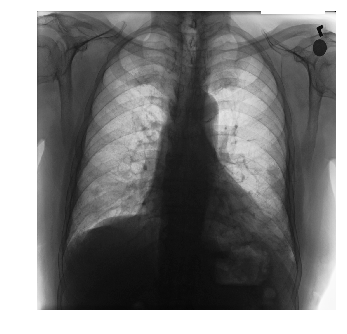

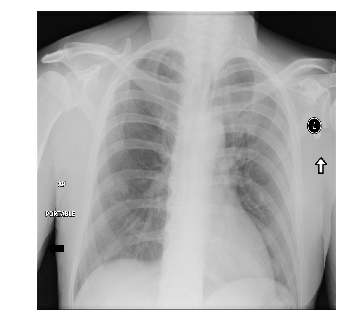

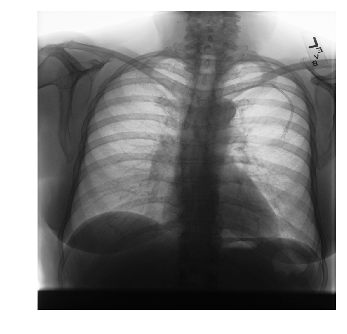

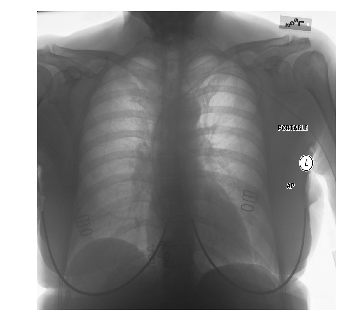

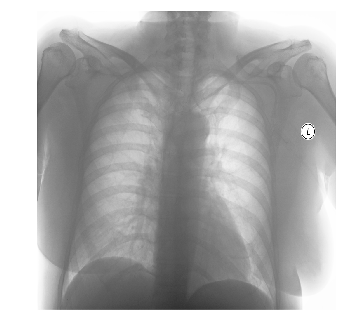

In [156]:
for i in range(5):
  img=mpimg.imread(os.path.join('data/images/')+files[i])
  imgplot = plt.imshow(img)
  plt.axis('off')
  plt.show()

In [154]:
labels[:5]

array([1, 0, 0, 0, 1])

In [161]:
model.predict(xrays, batch_size=None, verbose=1, steps=None)

4/4 [==============================] - 0s 5ms/step


array([[0.8226407 , 0.17735928],
       [0.8226407 , 0.17735928],
       [0.8226407 , 0.17735928],
       [0.8226407 , 0.17735928]], dtype=float32)